In [24]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
# Load Arabic dataset
X_train_arabic = pd.read_csv(r"Data\Arabic\csvTrainImages.csv", header=None)
Y_train_arabic = pd.read_csv(r"Data\Arabic\csvTrainLabel.csv", header=None)
X_test_arabic  = pd.read_csv(r"Data\Arabic\csvTestImages.csv", header=None)
Y_test_arabic  = pd.read_csv(r"Data\Arabic\csvTestLabel.csv", header=None)

# Check the shapes of the datasets
print("Arabic Dataset Shapes:")
print("X_train_arabic:", X_train_arabic.shape)
print("X_test_arabic:", X_test_arabic.shape)
print("Y_train_arabic:", Y_train_arabic.shape)
print("Y_test_arabic:", Y_test_arabic.shape)

Arabic Dataset Shapes:
X_train_arabic: (13440, 1024)
X_test_arabic: (3360, 1024)
Y_train_arabic: (13440, 1)
Y_test_arabic: (3360, 1)


In [26]:
# Load English dataset (ubyte)
import struct

def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

# Paths
train_images_path = r"Data\English\emnist-letters-train-images-idx3-ubyte"
train_labels_path = r"Data\English\emnist-letters-train-labels-idx1-ubyte"
test_images_path  = r"Data\English\emnist-letters-test-images-idx3-ubyte"
test_labels_path  = r"Data\English\emnist-letters-test-labels-idx1-ubyte"

# Read images and labels
x_train_english = read_idx(train_images_path)
x_test_english  = read_idx(test_images_path)
y_train_english = read_idx(train_labels_path)
y_test_english  = read_idx(test_labels_path)

print("\nOriginal English Dataset Shapes:")
print("x_train_english:", x_train_english.shape)
print("y_train_english:", y_train_english.shape)
print("x_test_english:", x_test_english.shape)
print("y_test_english:", y_test_english.shape)


Original English Dataset Shapes:
x_train_english: (124800, 28, 28)
y_train_english: (124800,)
x_test_english: (20800, 28, 28)
y_test_english: (20800,)


C:\Users\hosam\AppData\Local\Temp\ipykernel_26204\3395188747.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_labels_arabic, palette="Blues_r", ax=axes[0])
C:\Users\hosam\AppData\Local\Temp\ipykernel_26204\3395188747.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_labels_english, palette="Greens", ax=axes[1])


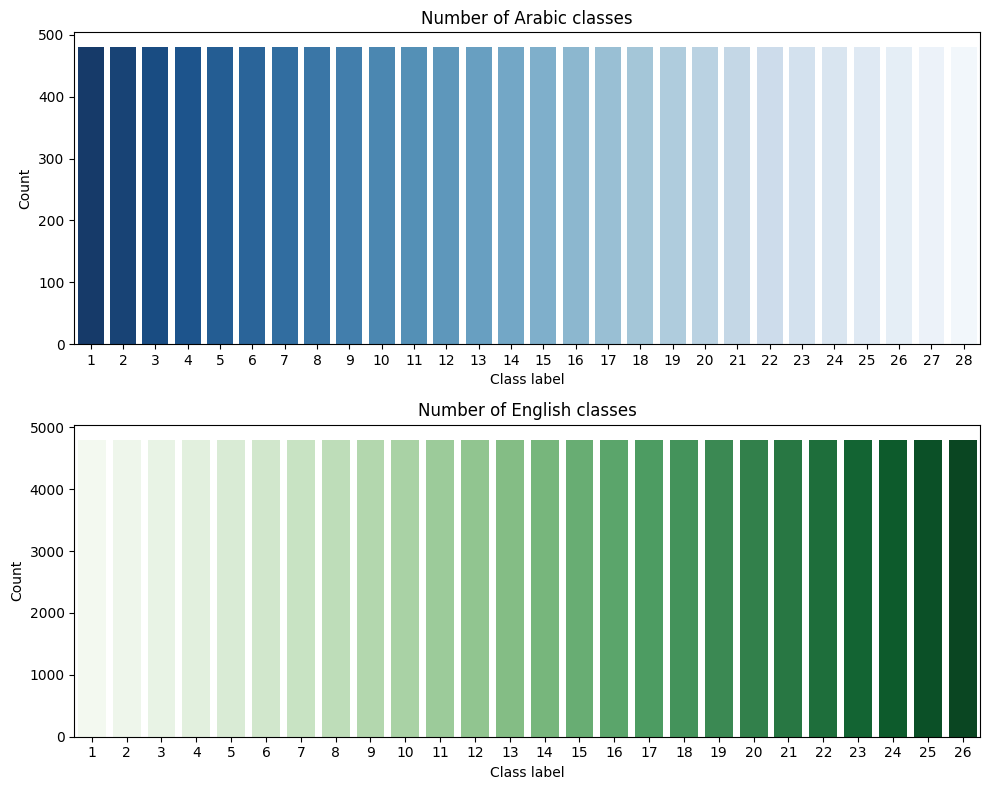

In [27]:
# Visualize the number of classes for both datasets
# labels
y_labels_arabic = Y_train_arabic.iloc[:, 0]  # extract the first column
y_labels_english = y_train_english

fig, axes = plt.subplots(2, 1, figsize=(10,8)) 

# Arabic classes
sns.countplot(x=y_labels_arabic, palette="Blues_r", ax=axes[0])
axes[0].set_title("Number of Arabic classes")
axes[0].set_xlabel("Class label")
axes[0].set_ylabel("Count")

# English classes
sns.countplot(x=y_labels_english, palette="Greens", ax=axes[1])
axes[1].set_title("Number of English classes")
axes[1].set_xlabel("Class label")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


In [44]:
class_mapping = {
    # Arabic
    1: "أ", 2: "ب", 3: "ت", 4: "ث", 5: "ج", 6: "ح", 7: "خ", 8: "د", 9: "ذ", 10: "ر",
    11: "ز", 12: "س", 13: "ش", 14: "ص", 15: "ض", 16: "ط", 17: "ظ", 18: "ع", 19: "غ",
    20: "ف", 21: "ق", 22: "ك", 23: "ل", 24: "م", 25: "ن", 26: "هـ", 27: "و", 28: "ي",
    
    # English uppercase
    29: "A", 30: "B", 31: "C", 32: "D", 33: "E", 34: "F", 35: "G", 36: "H", 37: "I", 38: "J",
    39: "K", 40: "L", 41: "M", 42: "N", 43: "O", 44: "P", 45: "Q", 46: "R", 47: "S", 48: "T",
    49: "U", 50: "V", 51: "W", 52: "X", 53: "Y", 54: "Z"
}


In [29]:
# Balance English dataset: 480 training samples per class, 120 test samples per class
print("===================== BALANCING ENGLISH DATASET =======================")

def balance_dataset(images, labels, samples_per_class, random_state=42):
    """
    Balance dataset to have exactly samples_per_class for each class.
    
    Args:
    - images: numpy array of images
    - labels: numpy array of labels
    - samples_per_class: number of samples to keep per class
    - random_state: random seed for reproducibility
    
    Returns:
        balanced_images, balanced_labels
    """
    np.random.seed(random_state)
    
    unique_classes = np.unique(labels)
    balanced_images = []
    balanced_labels = []
    
    for class_label in unique_classes:
        # Get indices for this class
        class_indices = np.where(labels == class_label)[0]
        
        # Sample or replicate to get exactly samples_per_class
        if len(class_indices) >= samples_per_class:
            # If we have enough samples, randomly select
            selected_indices = np.random.choice(class_indices, size=samples_per_class, replace=False)
        else:
            # If we don't have enough, sample with replacement
            selected_indices = np.random.choice(class_indices, size=samples_per_class, replace=True)
        
        balanced_images.append(images[selected_indices])
        balanced_labels.append(labels[selected_indices])
    
    # Concatenate all classes
    balanced_images = np.concatenate(balanced_images, axis=0)
    balanced_labels = np.concatenate(balanced_labels, axis=0)
    
    # Shuffle the balanced dataset
    shuffle_indices = np.random.permutation(len(balanced_labels))
    balanced_images = balanced_images[shuffle_indices]
    balanced_labels = balanced_labels[shuffle_indices]
    
    return balanced_images, balanced_labels

# Balance training set: 480 samples per class
x_train_english, y_train_english = balance_dataset(x_train_english, y_train_english, 480, random_state=42)

# Balance test set: 120 samples per class
x_test_english, y_test_english = balance_dataset(x_test_english, y_test_english, 120, random_state=42)

print("\nBalanced English Dataset Shapes:")
print("x_train_english:", x_train_english.shape)
print("y_train_english:", y_train_english.shape)
print("x_test_english:", x_test_english.shape)
print("y_test_english:", y_test_english.shape)

===================== BALANCING ENGLISH DATASET =======================

Balanced English Dataset Shapes:
x_train_english: (12480, 28, 28)
y_train_english: (12480,)
x_test_english: (3120, 28, 28)
y_test_english: (3120,)


In [30]:
# Verify class distribution
print("\nEnglish Training Set - Class Distribution:")
unique_train, counts_train = np.unique(y_train_english, return_counts=True)
for label, count in zip(unique_train, counts_train):
    print(f"\tClass {label}: {count} samples")

print("\nEnglish Test Set - Class Distribution:")
unique_test, counts_test = np.unique(y_test_english, return_counts=True)
for label, count in zip(unique_test, counts_test):
    print(f"\tClass {label}: {count} samples")




English Training Set - Class Distribution:
	Class 1: 480 samples
	Class 2: 480 samples
	Class 3: 480 samples
	Class 4: 480 samples
	Class 5: 480 samples
	Class 6: 480 samples
	Class 7: 480 samples
	Class 8: 480 samples
	Class 9: 480 samples
	Class 10: 480 samples
	Class 11: 480 samples
	Class 12: 480 samples
	Class 13: 480 samples
	Class 14: 480 samples
	Class 15: 480 samples
	Class 16: 480 samples
	Class 17: 480 samples
	Class 18: 480 samples
	Class 19: 480 samples
	Class 20: 480 samples
	Class 21: 480 samples
	Class 22: 480 samples
	Class 23: 480 samples
	Class 24: 480 samples
	Class 25: 480 samples
	Class 26: 480 samples

English Test Set - Class Distribution:
	Class 1: 120 samples
	Class 2: 120 samples
	Class 3: 120 samples
	Class 4: 120 samples
	Class 5: 120 samples
	Class 6: 120 samples
	Class 7: 120 samples
	Class 8: 120 samples
	Class 9: 120 samples
	Class 10: 120 samples
	Class 11: 120 samples
	Class 12: 120 samples
	Class 13: 120 samples
	Class 14: 120 samples
	Class 15: 120

C:\Users\hosam\AppData\Local\Temp\ipykernel_26204\2219831488.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_labels_arabic, palette="Blues_r", ax=axes[0])
C:\Users\hosam\AppData\Local\Temp\ipykernel_26204\2219831488.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_labels_english, palette="Greens", ax=axes[1])


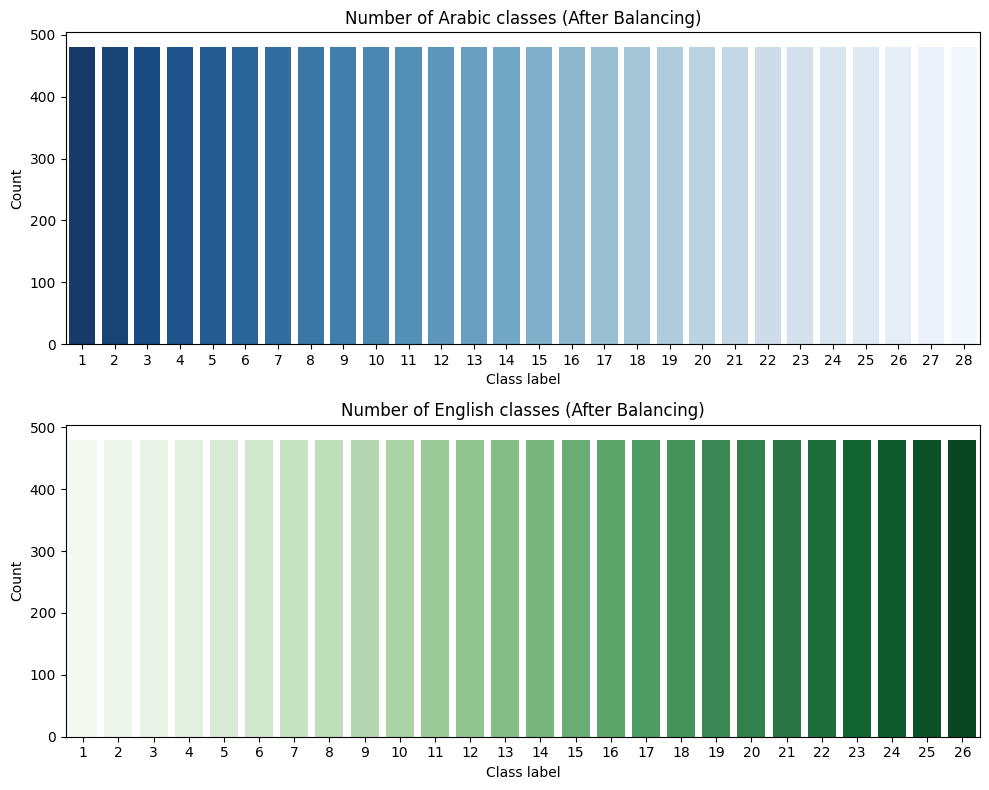

In [31]:
# Visualize the number of classes for both datasets

y_labels_arabic = Y_train_arabic.iloc[:, 0]  # extract the first column
y_labels_english = y_train_english

fig, axes = plt.subplots(2, 1, figsize=(10,8)) 

# Arabic classes
sns.countplot(x=y_labels_arabic, palette="Blues_r", ax=axes[0])
axes[0].set_title("Number of Arabic classes (After Balancing)")
axes[0].set_xlabel("Class label")
axes[0].set_ylabel("Count")

# English classes
sns.countplot(x=y_labels_english, palette="Greens", ax=axes[1])
axes[1].set_title("Number of English classes (After Balancing)")
axes[1].set_xlabel("Class label")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

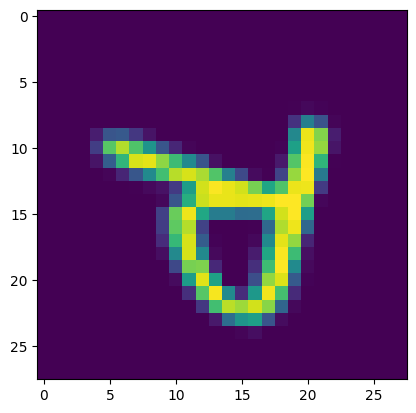

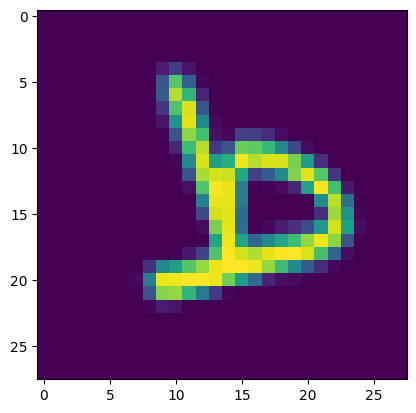

Label: ط


In [ ]:
# Arabic data preprocessing

# Convert DataFrame → NumPy array
X_train_arabic = X_train_arabic.values
X_test_arabic  = X_test_arabic.values

# Reshape
X_train_arabic = X_train_arabic.reshape(-1, 32, 32, 1)
X_test_arabic  = X_test_arabic.reshape(-1, 32, 32, 1)

# Resize to 28x28
X_train_arabic = tf.image.resize(X_train_arabic, (28,28)).numpy()
X_test_arabic  = tf.image.resize(X_test_arabic, (28,28)).numpy()

for i in range(len(X_train_arabic)):
    # Reshape and rotate image (EMNIST needs rotation)
    img = X_train_arabic[i]
    X_train_arabic[i] = np.rot90(img, k=-1)  # Rotate -90 degrees
    X_train_arabic[i] = np.fliplr(img)  # Flip left-right


# Labels → NumPy
Y_train_arabic = Y_train_arabic.to_numpy().flatten()
Y_test_arabic  = Y_test_arabic.to_numpy().flatten()

# Normalize
X_train_arabic = X_train_arabic / 255.0
X_test_arabic  = X_test_arabic / 255.0
print(f"Label: {class_mapping[Y_train_arabic[120]]}")


In [34]:

print("Arabic data shapes (after preprocessing):")
print("X_train_arabic:", X_train_arabic.shape)
print("X_test_arabic:", X_test_arabic.shape)
print("Y_train_arabic:", Y_train_arabic.shape)
print("Y_test_arabic:", Y_test_arabic.shape)


Arabic data shapes (after preprocessing):
X_train_arabic: (13440, 28, 28, 1)
X_test_arabic: (3360, 28, 28, 1)
Y_train_arabic: (13440,)
Y_test_arabic: (3360,)


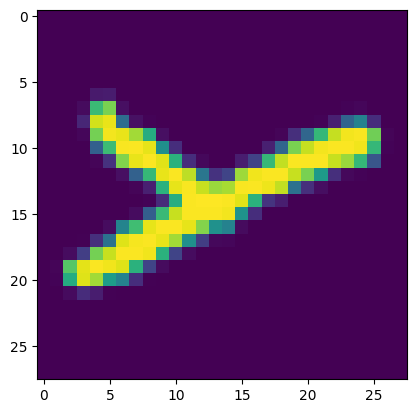

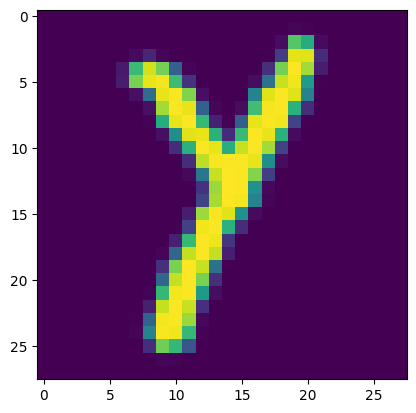

In [ ]:
# English data preprocessing

# Reshape 
x_train_english = x_train_english.reshape(-1, 28, 28, 1)
x_test_english  = x_test_english.reshape(-1, 28, 28, 1)


for i in range(len(x_train_english)):
    # Reshape and rotate image (EMNIST needs rotation)
    img = x_train_english[i]
    x_train_english[i] = np.rot90(img, k=-1)  # Rotate -90 degrees
    x_train_english[i] = np.fliplr(img)  # Rotate -90 degrees

# Normalize 
x_train_english = x_train_english / 255.0
x_test_english  = x_test_english / 255.0

# Convert labels to NumPy arrays (already done, but keeping for consistency)
y_train_english = np.array(y_train_english)
y_test_english  = np.array(y_test_english)


In [36]:
# Remap English labels from 1-26 to 29-54
print("\n===================== REMAPPING ENGLISH LABELS =======================")
print("Original English label range:", y_train_english.min(), "-", y_train_english.max())

# Add 28 to shift English labels to 29-54 range
y_train_english = y_train_english + 28
y_test_english = y_test_english + 28

print("Remapped English label range:", y_train_english.min(), "-", y_train_english.max())
print("Arabic label range:", Y_train_arabic.min(), "-", Y_train_arabic.max())


===================== REMAPPING ENGLISH LABELS =======================
Original English label range: 1 - 26
Remapped English label range: 29 - 54
Arabic label range: 1 - 28


In [37]:
# Check shapes
print("English data shapes (after preprocessing):")
print("x_train_english:", x_train_english.shape)
print("x_test_english:", x_test_english.shape)
print("y_train_english:", y_train_english.shape)
print("y_test_english:", y_test_english.shape)


English data shapes (after preprocessing):
x_train_english: (12480, 28, 28, 1)
x_test_english: (3120, 28, 28, 1)
y_train_english: (12480,)
y_test_english: (3120,)


In [38]:
# -----------------------------------
# Final Summary
# -----------------------------------
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print("Arabic Training: {} samples ({} per class)".format(X_train_arabic.shape[0], 480))
print("Arabic Testing: {} samples ({} per class)".format(X_test_arabic.shape[0], 120))
print("English Training: {} samples ({} per class)".format(x_train_english.shape[0], 480))
print("English Testing: {} samples ({} per class)".format(x_test_english.shape[0], 120))
print("All datasets normalized and ready for training")


FINAL SUMMARY
Arabic Training: 13440 samples (480 per class)
Arabic Testing: 3360 samples (120 per class)
English Training: 12480 samples (480 per class)
English Testing: 3120 samples (120 per class)
All datasets normalized and ready for training


In [39]:
# --- Combine Arabic + English ---
X_train = np.concatenate([X_train_arabic, x_train_english], axis=0)
Y_train = np.concatenate([Y_train_arabic, y_train_english], axis=0)

X_test= np.concatenate([X_test_arabic, x_test_english], axis=0)
Y_test = np.concatenate([Y_test_arabic, y_test_english], axis=0)

In [ ]:
import numpy as np
np.save("data/x_train.npy", X_train)
np.save("data/x_test.npy", X_test)
np.save("data/y_train.npy", Y_train)
np.save("data/y_test.npy", Y_test)

In [41]:
X_train.shape

(25920, 28, 28, 1)

In [57]:
import matplotlib.pyplot as plt
import random

def visualize_data_samples(X_train, Y_train, class_mapping):
    fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(6, 4))
    axes = axes.flatten()  # flatten 2D array → 1D list for easy looping

    for ax in axes:
        index = random.randint(0, len(X_train) - 1)
        img = X_train[index]
        label = class_mapping[Y_train[index]]

        ax.imshow(img)        # show image in current axis
        ax.set_title(label)   # set label
        ax.axis('off')        # remove ticks

    plt.tight_layout()
    plt.show()


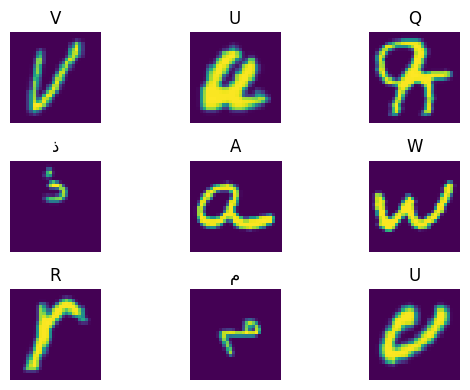

In [58]:
visualize_data_samples(X_train, Y_train,class_mapping)